# ETF Pipeline using s3

> ETF flow decompositions pipeline but querying data from arcticdb.
- skip_exec: true

In [ ]:
# | hide
# | eval: false
%load_ext autoreload
%autoreload 2

In [ ]:
# | default_exp etf_pipeline_s3

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import os

import click
from arcticdb import Arctic, QueryBuilder
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, Overrides, register_configs, get_config, NASDAQExchange
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
from lobster_tools.config import etf_to_equities
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from itertools import product
import datetime as dt
from dataclasses import dataclass
from functools import partial
import json
from typing import Literal, cast
import numpy as np
from pprint import pprint
from collections import namedtuple

In [ ]:
# | eval: false
register_configs()
cfg = get_config(overrides=Overrides.full_server)

In [ ]:
# | eval: false
directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities

markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

date_range = dt.date(2021, 1, 6), dt.datetime(2021, 1, 6, 16, 0)

In [ ]:
# | eval: false
# temp 
etfs = ['XLC']
equities = etf_to_equities['XLC']
tolerances = ["250us", "500us"]
markouts = ["30S", "1min", "2min", "4min"]
finest_resample = "30S"
max_markout = "4min"
dates = NASDAQExchange().trading_days

### Equity data

In [ ]:
# | eval: false
# connect to database
arctic = Arctic('s3://163.1.179.45:9100:lobster?access=minioadmin&secret=minioadmin')
arctic.list_libraries()
arctic_library = arctic["2021"]

In [ ]:
# | eval: false
all_symbols = arctic["2021"].list_symbols()
equities = list(set(equities).intersection(all_symbols))

In [ ]:
# | eval: false
# note to self that this behaviour not supported:
# q = q.apply("mid", (q["bid_price_1"] + q["ask_price_1"]) / 2 )
# equity_data = arctic_library.read(symbol="CB", query_builder=q, columns = ['bid_price_1', 'ask_price_1', 'mid'])

columns = [
    "time",
    "event",
    "order_id",
    "size",
    "price",
    "direction",
    "ask_price_1",
    "bid_price_1",
]
q = QueryBuilder()
# q = q.groupby(q.index.date)
# q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
equity_data = arctic_library.read(symbol="CB", query_builder=q, columns=columns).data

In [ ]:
# | eval: false
equity_data = arctic_library.read(symbol="CB", columns=["event"]).data
equity_data

,event
datetime,
2021-01-04 09:30:00.012146289,3
2021-01-04 09:30:00.335691896,1
2021-01-04 09:30:00.430775779,1
2021-01-04 09:30:00.430819815,1
2021-01-04 09:30:00.480884512,1
...,...
2021-12-31 15:59:59.583457776,1
2021-12-31 15:59:59.600117428,3
2021-12-31 15:59:59.917796851,1


In [ ]:
# | eval: false
def get_trading_days(df):
    return df.groupby(df.index.date).first().index

l = get_trading_days(equity_data)

In [ ]:
# | eval: false
def read_single_ticker_executions(ticker, date_range = None):
    """Read executions from database for single ticker."""

    columns = [
        "time",
        "event",
        "order_id",
        "size",
        "price",
        "direction",
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    return df

In [ ]:
# | eval: false
def read_multiple_tickers_executions(tickers, date_range = None):
    """Multiple version of `read_single_ticker_executions`."""
    return pd.concat(
        read_single_ticker_executions(ticker, date_range) for ticker in tickers 
    ).sort_index().astype({"ticker": "category"})

In [ ]:
# | eval: false
def date_to_tuple(date: dt.date):
    end_of_trading = dt.time(hour=16)
    return (date, dt.datetime.combine(date, end_of_trading))

def get_datetime_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = [x.date() for x in dates]
    date_tuples = [date_to_tuple(x) for x in dates]
    return date_tuples

def timestamp_to_tuple(timestamp):
    end_of_trading_day = pd.Timedelta(hours=16)
    # could also return datetimes with .to_pydatetime
    return (timestamp, timestamp + end_of_trading_day)

def get_timestamp_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    date_tuples = [timestamp_to_tuple(x) for x in dates]
    return date_tuples

One day

In [ ]:
# | eval: false
dates = get_datetime_tuples(start_date="2021-01-04", end_date="2021-01-06")
date = dates[0]

equity_executions=read_multiple_tickers_executions(tickers=equities, date_range=date)
etf_executions=read_multiple_tickers_executions(tickers=etfs, date_range=date)

In [ ]:
# | eval: false
def get_mids_for_etf(ticker, date_range):
    """Get only mids at a specified resample frequency."""
    columns = [
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    resampled_mid = df.mid.resample('30S', label='right', closed='left').last()
    return df, resampled_mid

In [ ]:
# | eval: false
df, mid = get_mids_for_etf(ticker="XLC", date_range=date)

In [ ]:
# | eval: false
def markout_to_int(markout: str, finest_resample: str = "30S"):
    """Maybe add stuff where checks this is almost an int"""
    ratio = pd.Timedelta(markout) / pd.Timedelta(finest_resample)
    if np.isclose(ratio, np.round(ratio), atol=1e-4):
        return int(np.round(ratio))
    else:
        ValueError("Markouts must be multiples of finest resample frequency")

markout_to_int("1min")

2

In [ ]:
# | eval: false
def compute_log_returns(mid):
    """Compute mid price dataframe at various markouts and compute log returns for those markouts"""
    df = pd.DataFrame(mid)
    markouts_str = ["30S", "1min", "2min"]

    Markout = namedtuple('Markout', ['str','int'])
    markouts = [Markout(x, markout_to_int(x)) for x in markouts_str]
    for markout in markouts:
        df[f"_{markout.str}"] = df.mid.shift(-markout.int)
    
    df = df.resample('5min', label='right', closed='right').last()

    # not sure how to drop all resampled buckets where there was a NaN before
    # for now simply drop last row of resampled dataframe
    df = df.iloc[:-1]

    # now compute log returns
    markout_columns = df.filter(regex="^_").columns.to_list()
    log_returns = np.log(df[markout_columns].divide(df.mid, axis=0))
    return log_returns

In [ ]:
# | eval: false
df = compute_log_returns(mid)
df

,_30S,_1min,_2min
datetime,,,
2021-01-04 09:35:00,-0.000519,-0.000815,-0.000445
2021-01-04 09:40:00,-0.000371,-0.000445,-0.000520
2021-01-04 09:45:00,0.000149,0.000297,0.000446
2021-01-04 09:50:00,-0.000446,-0.000297,-0.001488
2021-01-04 09:55:00,0.000223,0.000074,-0.000447
2021-01-04 10:00:00,0.000597,0.000000,0.000075
2021-01-04 10:05:00,0.000075,0.000373,0.000821
2021-01-04 10:10:00,0.000299,-0.000149,-0.000597
2021-01-04 10:15:00,0.000075,-0.000299,0.000299


In [ ]:
# | eval: false
# note to self - doing closed left when it's `continuous` as unlikely to have exactly on dot
def compute_ofi(df):
    """Compute ofi. Right stamped!"""
    ofi = (
        df[["size", "direction"]]
        .eval("signed_size = size * direction")
        .drop(columns=['direction'])
        .resample(resample_freq, label="right", closed="left")
        .sum()
        .eval('ofi = signed_size / size')
        .ofi
        .fillna(0)
    )
    return ofi
    # ehhh this was annoying. 
    return pd.DataFrame(ofi)

In [ ]:
# | eval: false
ofi = compute_ofi(etf_executions)
ofi

datetime
2021-01-04 09:35:00   -0.233211
2021-01-04 09:40:00   -0.215316
2021-01-04 09:45:00    0.181602
2021-01-04 09:50:00   -0.032230
2021-01-04 09:55:00    0.489251
2021-01-04 10:00:00    0.701882
2021-01-04 10:05:00    0.037394
2021-01-04 10:10:00    0.119455
2021-01-04 10:15:00    0.798590
2021-01-04 10:20:00   -0.199101
2021-01-04 10:25:00    0.412216
2021-01-04 10:30:00    0.048287
2021-01-04 10:35:00    0.532445
2021-01-04 10:40:00   -0.340745
2021-01-04 10:45:00    0.756987
2021-01-04 10:50:00    0.108726
2021-01-04 10:55:00    0.231574
2021-01-04 11:00:00    0.213201
2021-01-04 11:05:00    0.102729
2021-01-04 11:10:00    0.003110
2021-01-04 11:15:00   -0.341805
2021-01-04 11:20:00   -0.101538
2021-01-04 11:25:00    0.034277
2021-01-04 11:30:00    0.464369
2021-01-04 11:35:00    0.413732
2021-01-04 11:40:00    0.286445
2021-01-04 11:45:00   -0.181647
2021-01-04 11:50:00   -0.118633
2021-01-04 11:55:00    0.931175
2021-01-04 12:00:00   -0.421949
2021-01-04 12:05:00    0.398517

In [ ]:
# | eval: false
log_returns = compute_log_returns(mid)
log_returns

,_30S,_1min,_2min
datetime,,,
2021-01-04 09:35:00,-0.000519,-0.000815,-0.000445
2021-01-04 09:40:00,-0.000371,-0.000445,-0.000520
2021-01-04 09:45:00,0.000149,0.000297,0.000446
2021-01-04 09:50:00,-0.000446,-0.000297,-0.001488
2021-01-04 09:55:00,0.000223,0.000074,-0.000447
2021-01-04 10:00:00,0.000597,0.000000,0.000075
2021-01-04 10:05:00,0.000075,0.000373,0.000821
2021-01-04 10:10:00,0.000299,-0.000149,-0.000597
2021-01-04 10:15:00,0.000075,-0.000299,0.000299


In [ ]:
# | eval: false
def run_regressions(X, Y):
    model = MultiOutputRegressor(LinearRegression()).fit(X, Y)

    results = []
    for col, estimator in zip(Y.columns, model.estimators_):
        results.append({
            'target_markout': col,
            'r2': estimator.score(X, Y[col]),
            'coef': estimator.coef_,
            'intercept': estimator.intercept_
        })

    results_df = pd.DataFrame(results).set_index('target_markout')
    return results_df

In [ ]:
# | eval: false
X, Y = restrict_common_index(pd.DataFrame(ofi), log_returns)
run_regressions(X, Y)

,r2,coef,intercept
target_markout,,,
_30S,0.004472,[0.00010082245620010636],-0.000114
_1min,0.000253,[-3.109024706974797e-05],-0.000070
_2min,0.010044,[-0.00027934425715553667],-0.000068


### random stuff

In [ ]:
# | eval: false
from sklearn.neighbors import KDTree
z_etf = etf_executions.copy()
z_equity = equity_executions.copy()
etf_times = get_times(z_etf)
equity_times = get_times(z_equity)

tree = KDTree(equity_times, metric='l1')
tol = str_to_nanoseconds("500us")
res = tree.query_radius(etf_times, r=tol)

In [ ]:
# | eval: false
# # s.replace(to_replace=np.ndarray([]), value=None)
# # s.isna()
# # s.fillna(value=None, )

# s = pd.Series(res)
# z = pd.Series([res[0]] * len(res))
# s.dtype
# print(s.shape, s.dtype)
# print(z.shape, z.dtype)

# display(s)
# display(z)
# s.eq(z)

In [ ]:
# | eval: false
etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerances=tolerances)
etf_executions_neighbors

,time,event,order_id,size,price,direction,ask_price_1,bid_price_1,ticker,mid,_500us_neighbors
datetime,,,,,,,,,,,
2021-01-04 09:30:01.095900732,34201.095901,5,0,100,67.775,1,67.79,67.60,XLC,67.695,None
2021-01-04 09:30:02.675304503,34202.675305,4,33616440,20,67.790,-1,67.79,67.70,XLC,67.745,None
2021-01-04 09:30:02.675304503,34202.675305,4,33721376,100,67.790,-1,67.84,67.70,XLC,67.770,None
2021-01-04 09:30:10.075087808,34210.075088,5,0,100,67.770,1,67.81,67.76,XLC,67.785,None
2021-01-04 09:30:10.093825097,34210.093825,4,34697420,100,67.760,1,67.84,67.70,XLC,67.770,None
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-04 14:14:23.308792896,51263.308793,5,0,45,66.340,1,66.35,66.33,XLC,66.340,None
2021-01-04 14:14:26.803697400,51266.803697,4,693398352,100,66.350,1,66.36,66.34,XLC,66.350,"[214376, 214375, 214374, 214377]"
2021-01-04 14:14:29.290287726,51269.290288,4,693435720,119,66.350,1,66.36,66.34,XLC,66.350,None


In [ ]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

neighbor_statistics = compute_neighbor_statistics(etf_executions_neighbors)
# pd.DataFrame({'has_neighbor':neighbor_statistics}).style.format("{:.2%}")
pd.DataFrame({'has_neighbor':neighbor_statistics})

NameError: name 'etf_executions_neighbors' is not defined

In [ ]:
# | eval: false
etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)

In [ ]:
# | export
def marginalize(df: pd.DataFrame) -> pd.DataFrame:
    """Quidk implentation just for one feature. Just for _500us!"""
    # TODO think whether inplace is better
    df = df.copy()
    df["_500us_num_trades"] = df._500us_num_trades_os_af + df._500us_num_trades_os_bf + df._500us_num_trades_ss_af + df._500us_num_trades_ss_bf
    # same for others...
    return df

In [ ]:
# | eval: false
etf_executions_features = marginalize(etf_executions_features)

In [ ]:
# | eval: false
def sparse_to_dense(df):
    """Convert all sparse columns to dense"""
    sparse_columns = [col for col in df.columns if pd.api.types.is_sparse(df[col].dtype)]
    df[sparse_columns] = df[sparse_columns].sparse.to_dense()
    return df

In [ ]:
# | eval: false
def keep_bins(s: pd.Series):
    value_counts = s.value_counts().sort_index()
    CUTOFF = 50
    not_enough_data = value_counts < CUTOFF
    up_to = not_enough_data.idxmax()
    return up_to

keep_bins(etf_executions_features._500us_num_trades)
# etf_executions_features._500us_num_trades.value_counts().sort_index()

6

In [ ]:
# | eval: false
# def relabel_more_than_max_bins(max_bin: int):
non_sparse = sparse_to_dense(etf_executions_features)
non_sparse.dtypes

time                              float64
event                               int64
order_id                            int32
size                                int64
price                             float64
direction                            int8
ask_price_1                       float64
bid_price_1                       float64
ticker                           category
mid                               float64
_500us_neighbors                   object
_500us_distinct_tickers_ss_bf       int64
_500us_distinct_tickers_ss_af       int64
_500us_distinct_tickers_os_bf       int64
_500us_distinct_tickers_os_af       int64
_500us_notional_ss_bf             float64
_500us_notional_ss_af             float64
_500us_notional_os_bf             float64
_500us_notional_os_af             float64
_500us_num_trades_ss_bf             int64
_500us_num_trades_ss_af             int64
_500us_num_trades_os_bf             int64
_500us_num_trades_os_af             int64
_500us_num_trades                 

In [ ]:
# | eval: false
# put in function
df = etf_executions_features
col = "_500us_num_trades"
max_bin = keep_bins(df[col])
df.loc[df._500us_num_trades >= max_bin, "_500us_num_trades"] = max_bin
df.loc[df._500us_num_trades >= max_bin, "_500us_num_trades"]

datetime
2021-01-04 09:31:13.066740533    6
2021-01-04 09:32:26.084521052    6
2021-01-04 09:32:26.084521052    6
2021-01-04 09:32:26.084521052    6
2021-01-04 09:38:23.685961965    6
                                ..
2021-01-04 14:11:27.480599639    6
2021-01-04 14:11:27.817002265    6
2021-01-04 14:11:28.040307953    6
2021-01-04 14:12:00.024691844    6
2021-01-04 14:12:00.024691844    6
Name: _500us_num_trades, Length: 325, dtype: int64

In [ ]:
# | eval: false
def add_pnl_columns(df):
    df = df.copy(deep=True)
    CLOSE_PRICE = ( df.query("direction == 1").iloc[-1].price + df.query("direction == -1").iloc[-1].price ) / 2
    df = df.assign(pnl_to_close = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction,
              hit_ratio = lambda df_: ((df_.pnl_to_close) > 0))
    return df

In [ ]:
# | eval: false
etf_executions_features_pnl = add_pnl_columns(etf_executions_features)

# groupby statistics
etf_executions_features_pnl.groupby(col).agg({"pnl_to_close":['mean', 'std'], "hit_ratio":["mean", "std"]})

pnl_to_close            hit_ratio          
                          mean        std      mean       std
_500us_num_trades                                            
0                   -13.156701  80.250982  0.426354  0.494640
1                   -22.553614  68.747571  0.347222  0.477193
2                   -20.460683  75.383876  0.422857  0.495431
3                   -18.027535  69.972274  0.418182  0.495518
4                     9.207179  74.801080  0.651163  0.479398
5                    12.661448  70.571541  0.628571  0.486675
6                   -16.779300  69.144066  0.480000  0.500370

In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features[etf_executions_features.event.isin([4,5])]
etf_executions_features_no_auc = etf_executions_features_no_auc.query(f"_500us_num_trades <= {ENOUGH_DATA}").assign(pnl_to_close = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction)

In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features_no_auc.assign(hit_ratio = lambda df_: ((df_.pnl_to_close) > 0 ))
summary_statistics = etf_executions_features_no_auc.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_raio=("hit_ratio","mean"))

In [ ]:
# | eval: false
etf_executions_features.groupby(by="_500us_num_trades").agg({"mid":"mean"})

/tmp/ipykernel_297932/744194592.py:1: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  etf_executions_features.groupby(by="_500us_num_trades").agg({"mid":"mean"})


,mid
_500us_num_trades,
0,66.568209
1,66.499884
2,66.573457
3,66.457636
4,66.437965
5,66.454429
6,66.341585
7,66.211429
8,66.485000


## PoolProcess for many dates

In [ ]:
# | eval: false
def dump_to_pickle(date):
    print(etfs)
    print(equities)
    equity_executions=read_multiple_tickers_executions(tickers=equities, date_range=date)
    etf_executions=read_multiple_tickers_executions(tickers=etfs, date_range=date)

    etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerances=tolerances)
    etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)
    etf_executions_features_pnl = add_pnl_columns(etf_executions_features)

    # for now just one etf

    # if want to pickle
    # assert len(etfs) == 1
    # etf_name = etfs[0]
    date_str = dt.datetime.combine(date[0], dt.datetime.min.time()).strftime("%Y-%m-%d")
    # etf_executions_features_pnl.to_pickle(f"../features/{etf_name}_{date_str}")
    print(f"done {date_str}")
    return etf_executions_features_pnl

In [ ]:
# | eval: false
def filter_to_existing_equities(equities):
    existing_symbols = arctic_library.list_symbols() 
    return list(set(equities).intersection(set(existing_symbols)))

equities = filter_to_existing_equities(equities)
print(equities)

['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']


In [ ]:
# | eval: false
from concurrent.futures import ProcessPoolExecutor, wait, as_completed
dates = NASDAQExchange().trading_days
dates = dates[:10]
dates = [date_to_tuple(x) for x in dates]

# dump_to_pickle(dates[0])

with ProcessPoolExecutor(max_workers=10) as executor:
    dfs = list(executor.map(dump_to_pickle, dates))
df = pd.concat(dfs)

['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']


['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']
['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']
['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']






['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']
['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL', 'OMC', 'NFLX', 'NWSA', 'IPG', 'FOXA', 'T', 'DIS', 'EA', 'VZ', 'DISH', 'FOX']['CHTR', 'CMCSA', 'TMUS', 'TTWO', 'NWS', 'ATVI', 'GOOG', 'GOOGL',

In [ ]:
# | eval: false
l = []
nums = etf_executions_features[col].unique()
nums.sort()

for num in nums:
    subset = etf_executions_features[etf_executions_features[col] == num]
    ofi = compute_ofi(subset)
    ofi = ofi.rename(f"ofi_{num}")
    l.append(ofi)

multi_ofi = pd.concat(l, axis=1).fillna(0)

In [ ]:
# | eval: false
multi_ofi

,ofi_0,ofi_1,ofi_2,ofi_3,ofi_4,ofi_5,ofi_6
datetime,,,,,,,
2021-01-04 09:35:00,-0.400063,0.000000,-0.666667,1.000000,-1.000000,0.000000,1.000000
2021-01-04 09:40:00,-0.306327,-0.500000,1.000000,-1.000000,0.134199,0.000000,1.000000
2021-01-04 09:45:00,0.175665,0.753998,-0.666667,0.000000,1.000000,0.555556,0.000000
2021-01-04 09:50:00,-0.361912,1.000000,1.000000,0.000000,1.000000,-1.000000,1.000000
2021-01-04 09:55:00,0.418491,0.000000,1.000000,0.147122,0.000000,0.000000,1.000000
2021-01-04 10:00:00,0.669800,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-04 10:05:00,0.114024,1.000000,0.450549,-1.000000,-0.298246,-0.834300,1.000000
2021-01-04 10:10:00,0.097965,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
2021-01-04 10:15:00,0.705123,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [ ]:
# | eval: false
X, Y = restrict_common_index(multi_ofi, log_returns)
run_regressions(X, Y)

,r2,coef,intercept
target_markout,,,
_30S,0.105933,"[0.00018300462347454918, 0.0001439937930976026...",-0.000122
_1min,0.079992,"[-4.585571051037398e-06, 0.0001596598395570741...",-0.000065
_2min,0.097893,"[3.3182734280349274e-05, -1.149992564084465e-0...",-0.000027


In [ ]:
# | eval: false
# could do groupby

compute_ofi(etf_executions_features.query("_500us_num_trades == 1"))

,ofi
datetime,
2021-01-04 09:40:00,-0.500000
2021-01-04 09:45:00,0.753998
2021-01-04 09:50:00,1.000000
2021-01-04 09:55:00,0.000000
2021-01-04 10:00:00,0.000000
2021-01-04 10:05:00,1.000000
2021-01-04 10:10:00,1.000000
2021-01-04 10:15:00,1.000000
2021-01-04 10:20:00,1.000000


<Axes: >

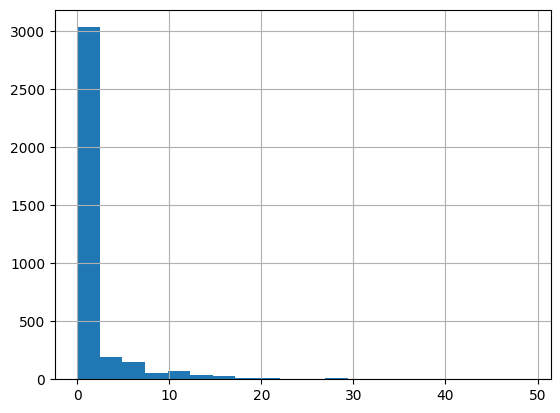

In [ ]:
# | eval: false
etf_executions_features._500us_num_trades.hist(bins=20)

In [ ]:
# | eval: false
iso, non_iso = split_isolated_non_isolated(etf_executions=etf_executions_features, tolerance="500us")
non_iso.columns

In [ ]:
# | eval: false
has_neighbors = etf_executions_neighbors['_500us_neighbors'].notna()
etf_executions_has_neighbors = etf_executions_neighbors[has_neighbors]
etf_executions_has_neighbors

In [ ]:
# | eval: false
has_neighbors = etf_executions_neighbors.filter(regex="neighbors").notna()
display(has_neighbors)
pd.Series(has_neighbors)
has_neighbors.sum()
# has_neighbors[has_neighbors == True]
# type(has_neighbors)
# etf_executions_has_neighbors = etf_executions_neighbors.loc[has_neighbors, :]

# etf_executions_has_neighbors.notna().sum()

# (has_neighbors.index == etf_executions_neighbors.index).sum()
# etf_executions_neighbors[etf_executions_neighbors.filter(regex="neighbors").notna()].dropna()
# etf_executions_has_neighbors = etf_executions_neighbors.loc[has_neighbors]
# etf_executions_has_neighbors

In [ ]:
# | eval: false
etf_executions_has_neighbors = etf_executions_neighbors[etf_executions_neighbors]
etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)

### Load with ArcticDB

In [ ]:
# | eval: false
def print_symbols_with_trading_halts():
    """Print symbols that have trading halts. Could put em in a list if needed."""
    for ticker in arctic_library.list_symbols():
        print(ticker)
        q = QueryBuilder()
        q = q[q.event.isin([7,9,10,11])]
        df = arctic_library.read(symbol=ticker, query_builder=q).data

        if len(df) != 0:
            print(f"This one: {ticker}")
            break

In [ ]:
#TODO: pickle and load pickles.. looks like nbdev doesn't work with cell magics

In [ ]:
# | eval: false
%store etf_executions
%store equity_executions

In [ ]:
# | eval: false
%store -r

In [ ]:
# | eval: false
ofi_all = ofi(etf_executions, resample_freq="5T", suffix="all")
ofi_all

In [ ]:
# | eval: false
markout_times = markout_returns(ofi_all, markouts=markouts)
markout_times

In [ ]:
# | eval: false
mids = etf_executions.eval("bid_price_1 + (ask_price_1 - bid_price_1) / 2").resample(finest_resample, label="right").last()
mids = pd.DataFrame(mids, columns=etfs)
# mids.resample(resample_freq, label="right").last()

In [ ]:
# | eval: false
mids

In [ ]:
# | eval: false
# markout_times = markout_returns(ofi_all, markouts=markouts)
# mids = [resample_mid(lobster.book, resample_freq=finest_resample).rename(lobster.data.ticker) for lobster in etf_lobsters]
# mids = pd.concat(mids, axis=1)
# mids

In [ ]:
# | eval: false
def compute_returns():
    index = clip_for_markout(etf_executions.resample(resample_freq, label="right").last(), max_markout=max_markout).index

    returns = {}
    for ticker in etfs:
        df = pd.DataFrame(index=index)
        print(df)
        for markout in ["0S"] + markouts:
            df[f"_{markout}"] = mids.loc[df.index + pd.Timedelta(markout), ticker].values

        for markout in markouts:
            df.eval(f"return_{markout} = (_{markout} / _0S ) - 1", inplace=True)

        df["return_contemp"] = mids[ticker].resample("5T").first().pct_change()
        df_returns = df.filter(regex="return")
        df_returns.columns = [column.replace("return_", "") for column in df_returns.columns]
        df_returns.columns = [("_" + column if column[0].isdigit() else column) for column in df_returns.columns ]
        # new addition
        df_returns.fillna(0, inplace=True)
        returns[ticker] = df_returns
    return returns

returns = compute_returns()
returns[etfs[0]]

In [ ]:
# | eval: false
returns[etfs[0]].sample(10)

In [ ]:
# | eval: false
def regression_table(
    X: pd.DataFrame,  # covariates. in this case, OFI for a single ETF
    y: pd.DataFrame,  # response variable. in this case, mid to mid returns at various markouts
):
    """Compute X.len * y.len univariate regressions. For each column in X, regress against each one column of y."""
    X, y = restrict_common_index(X, y)
    
    regression_results = []

    for x_col_name, y_col_name in product(X.columns, y.columns):
        x_col = X[x_col_name].values.reshape(-1, 1)
        y_col = y[y_col_name].values
        
        model = LinearRegression(fit_intercept=False)
        model.fit(x_col, y_col)

        intercept = model.intercept_
        coefficient = model.coef_[0]
        r2 = model.score(x_col, y_col)

        regression_results.append(
            {
                "id": x_col_name + "_" + y_col_name,
                "intercept": intercept,
                "coefficient": coefficient,
                "r2": r2,
            }
        )
        
    regression_results_df = pd.DataFrame(regression_results)
    regression_results_df.set_index("id", inplace=True)
    return regression_results_df

regression_table(ofi_all, returns[etfs[0]])

In [ ]:
# | eval: false
drop_all_neighbor_cols(etf_executions)

In [ ]:
# | eval: false
etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerance=tolerances)
etf_executions_neighbors

In [ ]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(
        regex="^_"
    ).notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics


neighbor_statistics = compute_neighbor_statistics(etf_executions_neighbors)
# pd.DataFrame({'has_neighbor':neighbor_statistics}).style.format("{:.2%}")
pd.DataFrame({"has_neighbor": neighbor_statistics})

In [ ]:
# | eval: false
etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)

In [ ]:
# | eval: false
etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

In [ ]:
# | eval: false
etf_executions_features._500us_num_trades.hist()

In [ ]:
# | eval: false
val_counts = etf_executions_features.value_counts(subset="_500us_num_trades")
val_counts.where(val_counts > 100).dropna().index.values.tolist()

In [ ]:
# | eval: false
ENOUGH_DATA = 7
etf_executions_features.query(f"_500us_num_trades <= {ENOUGH_DATA}")

CLOSE_PRICE = ( etf_executions_features.query("direction == 1").iloc[-1].price + etf_executions_features.query("direction == -1").iloc[-1].price ) / 2
print(CLOSE_PRICE)

In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features[etf_executions_features.event.isin([4,5])]
etf_executions_features_no_auc = etf_executions_features_no_auc.query(f"_500us_num_trades <= {ENOUGH_DATA}").assign(pnl_to_close = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction)


In [ ]:
# | eval: false
etf_executions_features_no_auc = etf_executions_features_no_auc.assign(hit_ratio = lambda df_: ((df_.pnl_to_close) > 0 ))
summary_statistics = etf_executions_features_no_auc.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_raio=("hit_ratio","mean"))

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

### Multi-day

In [ ]:
# | eval: false
df = etf_executions_features_no_auc

In [ ]:
# | eval: false
closing_prices = df.resample('D').transform('last').price

In [ ]:
# | eval: false
df["closing_price"] = closing_prices

In [ ]:
# | eval: false
df.eval("pnl_to_close = (closing_price - price) * 1e4 * direction", inplace=True)
df.eval("hit_ratio = (pnl_to_close > 0)", inplace=True)

In [ ]:
# | eval: false
summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

In [ ]:
# | eval: false
%store etf_executions_neighbors
%store etf_executions_features

In [ ]:
# etf_executions_features = marginalise(etf_executions_features, over='same_sign/opposite_sign')

In [ ]:
# etf_executions_features.columns

In [ ]:
# etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

In [ ]:
# etf_execution_features.filter(regex="^_").hist()

In [ ]:
# easy way without query builder
# date_range = [datetime.date(year=2020, month=1, day=2), datetime.date(year=2020, month=1, day=3)]
# df = library.read(ticker, date_range=date_range).data

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()